In [1]:
import dask
from dask.distributed import Client, wait
from dask import delayed

client = Client(n_workers=7, threads_per_worker=1) 
#client = Client()

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43879,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:43813,Total threads: 1
Dashboard: /proxy/37439/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:38721,


In [2]:
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import glob
import os

Import Justin's faux ffdi data
- Used sfcWindmax
- hrusmin
- tasmax

for daily max vaules of faux ffdi

In [3]:
in_dir = f"/g/data/ia39/users/jp0715/BARRA"

In [4]:
infiles_faux_ffdi=glob.glob(in_dir+f'/BARRA_dwi_ffdi*.nc')

In [5]:
faux_ffdi_ds = xr.open_mfdataset(infiles_faux_ffdi)['dwi_ffdi']

In [6]:
faux_ffdi_ds

<xarray.DataArray 'dwi_ffdi' (time: 16436, lat: 691, lon: 886)> Size: 40GB
dask.array<concatenate, shape=(16436, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01T12:00:00 ... 2023-12-31T1...
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Attributes:
    long_name:      afternoon FFDI equivalent based on DWI
    standard_name:  dwi_ffdi
    units:          C km h-1

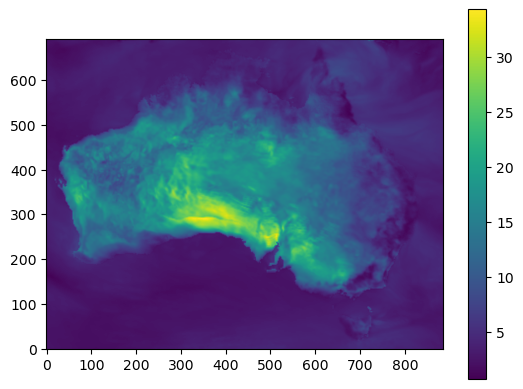

In [7]:
plt.imshow(faux_ffdi_ds[0], origin='lower')
plt.colorbar()

In [8]:
in_dir_barra = f"/g/data/ia39/australian-climate-service/release/CORDEX/output-CMIP6/DD/AUST-05i/BOM/ERA5/historical/hres/BARRAR2/v1/day/tasmax/v20241216/"

In [9]:
#import data
infiles_tasmax=glob.glob(in_dir_barra+f'tasmax_AUST-05i_ERA5_historical_hres_BOM_BARRAR2_v1_day_*.nc')

In [10]:
tasmax_ds = xr.open_mfdataset(infiles_tasmax)['tasmax']

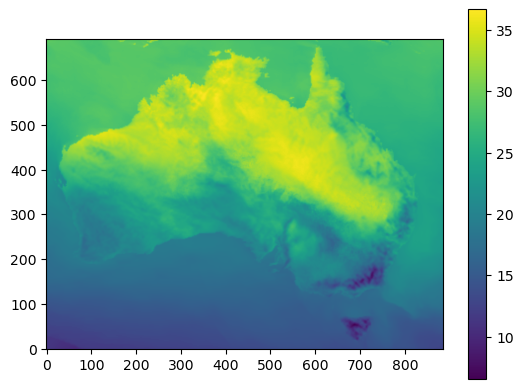

In [11]:
plt.imshow(tasmax_ds[114], origin='lower')
plt.colorbar()

In [12]:
dwi = faux_ffdi_ds[100]*2/(tasmax_ds[100] + 12)

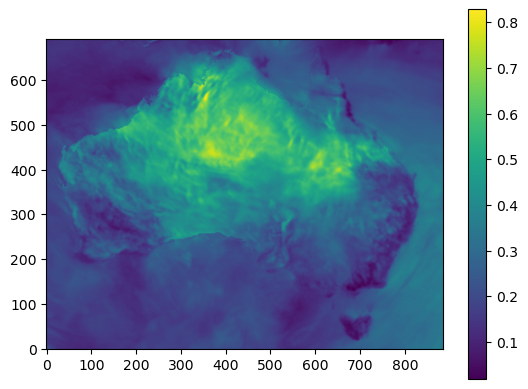

In [13]:
plt.imshow(dwi, origin='lower')
plt.colorbar()

In [14]:
def calc_dwi_from_faux_ffdi(ds_faux_ffdi, ds_temp):
    dwi = ds_faux_ffdi*2/(ds_temp + 12)
    
    dwi.attrs = {
    'long_name': 'dwi computed from faux_ffdi and tasmax, from BARRA 1979 - 2023 inclusive',
    'standard_name': 'dwi',
    #'units': 'km h-1',
    'program' : 'Australian Climate Service (ACS)',
    'summary' : f'Fire weather metric: BARRA dwi',
    'naming_authority' : "Bureau of Meteorology",
    'publisher_type' : "group",
    'publisher_type' : "group" ,
    'publisher_institution' : "Bureau of Meteorology",
    'publisher_name' : "Bureau of Meteorology",
    'publisher_url' : "http://www.bom.gov.au",
    'creator_type' : "institution" ,
    'creator_institution' : "Bureau of Meteorology" ,
    'contact' : "Naomi Benger (naomi.benger@bom.gov.au)" ,
    'institute_id' : "BOM" ,
    'institution' : "Bureau of Meteorology",
    }

    ds_dwi = xr.Dataset({'dwi' : dwi})
    ds_temp.close()
    ds_faux_ffdi.close()
    return ds_dwi

In [15]:
#calculate the ds
dwi_ds = calc_dwi_from_faux_ffdi(faux_ffdi_ds, tasmax_ds)

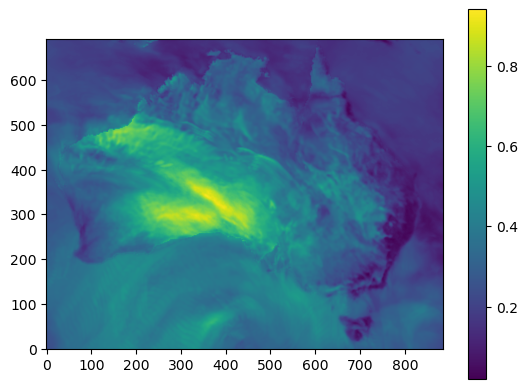

In [16]:
plt.imshow(dwi_ds['dwi'][200], origin='lower')
plt.colorbar()

In [17]:
dwi_ds

<xarray.Dataset> Size: 40GB
Dimensions:  (time: 16436, lat: 691, lon: 886)
Coordinates:
  * time     (time) datetime64[ns] 131kB 1979-01-01T12:00:00 ... 2023-12-31T1...
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Data variables:
    dwi      (time, lat, lon) float32 40GB dask.array<chunksize=(1, 691, 886), meta=np.ndarray>

In [18]:
#required_vars = {"tasmax", "hursmin", "sfcWindmax"}
 
#A = 5
#B = 20
#C = 0
#D = 25
#tasmax = barra_data["tasmax"]["tasmax"]
#hursmin = barra_data["hursmin"]["hursmin"]
#sfcWindmax = barra_data["sfcWindmax"]["sfcWindmax"]
 
#result= acs_calc_functions.calc_dwi_ffdi(tasmax, hursmin, sfcWindmax, A, B, C, D)

# Create output directory
output_dir = os.path.join("/g/data/mn51/users/nb6195/BARRA_DWI")
os.makedirs(output_dir, exist_ok=True)
 
# Create filename and full path
filename = "BARRA_dwi"
filepath = os.path.join(output_dir, filename)
print(filepath)
# Write to NetCDF
        #result.to_netcdf(filepath,engine='netcdf4')
        #Try writing year by year
start_year = int(dwi_ds.time.dt.year.min().item())
end_year = int(dwi_ds.time.dt.year.max().item())
 

/g/data/mn51/users/nb6195/BARRA_DWI/BARRA_dwi


In [19]:
for year in range(start_year, end_year + 1):
    # Select data for the year
    result_year = dwi_ds.sel(time=str(year))
 
    time_len = result_year.sizes['time']
 
 
    # Optional: rechunk and cast to float32
    # The chunk in this line is important for writing of the file
    result_year = result_year.chunk({'time': -1}).astype("float32") #have time continuous
    #result_year = result_year.chunk({'time': 365}).astype("float32")
 
    # Convert to dataset
    ds_year = result_year#.to_dataset(name="dwi")
 
    # Define encoding
    encoding = {
            "dwi": {
                "dtype": "float32",
                "zlib": True,
                "complevel": 4, #mid-level compression, goes from 1 to 9
                #"chunksizes": (time_len, 691, 886)
                "chunksizes": (1, 691, 886)
            }
    }
 
    # Define output path
    out_path = f"{filepath}_{year}.nc"
 
    # Write NetCDF
    #ds_year.to_netcdf(out_path, engine="netcdf4", encoding=encoding)
    ds_year.to_netcdf(out_path, engine="netcdf4", encoding=encoding)